In [91]:
# DIY diffusion bridge using MH sampling and Girsanov formula
# 2d version

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [92]:
from scipy.integrate import ode

In [93]:
def f(t, y):
    return [y[1], -np.sin(y[0])]

In [94]:
r = ode(f).set_integrator('dopri5')

In [95]:
y0 = np.array([1.,0.])
t0 = 0.

In [96]:
r.set_initial_value(y0, t0)

In [97]:
t1 = 6.7/16
numsteps = 1000
dt = (t1-t0)/numsteps
traj = np.zeros((numsteps, 2))
j = 0
while r.successful() and j < numsteps:
    r.integrate(r.t+dt)
    traj[j, :] = r.y
    j += 1

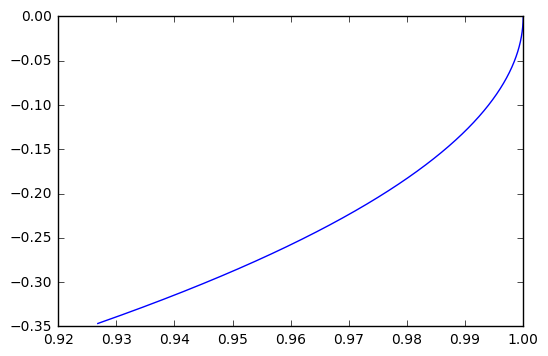

In [98]:
plt.plot(traj[:,0],traj[:,1])

In [103]:
# x = np.array([[-1.0,0.0],[0.0,1.0]])
x = traj[[0,999],:]
t = np.array([0., 6.7/16])

In [144]:
gamma = np.array([.2,.25])

In [145]:
def brownianbridgeM(gvec, xin, tin, n):
    h = (tin[1]-tin[0])/n
    tvec = tin[0] + (1+np.arange(n))*h
    h12 = np.sqrt(h)
    wincs = np.random.multivariate_normal(mean=np.zeros(len(gvec)),
                                          cov=h*np.diag(np.square(gvec)),
                                          size=n)
    w = np.cumsum(wincs,axis=0).T
    bridge = xin[0,:,None] + w
    bridge -= ((tvec - tin[0])/(tin[1]-tin[0]))*(w[:,n-1,None] + xin[0,:,None] - xin[1,:,None])
    return tvec, bridge

In [146]:
# define drift function
def drift(x):
    f = np.zeros(x.shape)
    f[0,:] = x[1,:]
    f[1,:] = -np.sin(x[0,:])
    return f

In [147]:
xaux = np.array([[0.0,0.0],[0.0,0.0]])

In [148]:
# girsanov LOG likelihood
def girsanovM(gvec, path, dt):
    b = drift(path)
    u = np.dot(np.diag(np.power(gvec,-2)), b)
    int1 = np.tensordot(u[:,:-1], np.diff(path,axis=1))
    # int2 = np.tensordot(u, b)
    u2 = np.einsum('ij,ji->i',u.T,b)
    int2 = np.sum(0.5*(u2[1:] + u2[:-1]))*dt
    r = int1 - 0.5*int2
    return r

Acceptance rate during burn-in: 0.78
Acceptance rate post burn-in: 0.776


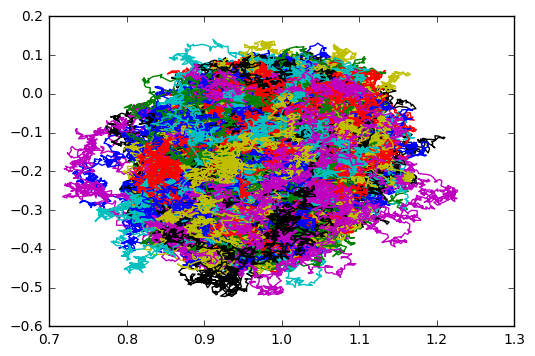

In [149]:
# MH sampler
numsteps = 1000
burnin = 100
n = 1000
h = (t[1]-t[0])/n

# tout, xcur = brownianbridgeM(gamma,xaux,t,n)
# xcur += traj.T
tout, xcur = brownianbridgeM(gamma,x,t,n)
oldlik = girsanovM(gvec=gamma, path=xcur, dt=h)
arburn = np.zeros(burnin)
for jj in range(burnin):
    # _, prop = brownianbridgeM(gamma,xaux,t,n)
    # prop += traj.T
    _, prop = brownianbridgeM(gamma,x,t,n)
    proplik = girsanovM(gvec=gamma, path=prop, dt=h)
    rho = proplik - oldlik
    if (rho >= np.log(np.random.uniform())):
        xcur = prop
        oldlik = proplik
        arburn[jj] = 1
        
print("Acceptance rate during burn-in:", np.mean(arburn))

arsamp = np.zeros(numsteps)
for jj in range(numsteps):
    # _, prop = brownianbridgeM(gamma,xaux,t,n)
    # prop += traj.T
    _, prop = brownianbridgeM(gamma,x,t,n)
    proplik = girsanovM(gvec=gamma, path=prop, dt=h)
    rho = proplik - oldlik
    if (rho >= np.log(np.random.uniform())):
        xcur = prop
        oldlik = proplik
        arsamp[jj] = 1
        _ = plt.plot(xcur[0,:],xcur[1,:])
    # samples[jj,:] = xcur

print("Acceptance rate post burn-in:", np.mean(arsamp))